<a href="https://colab.research.google.com/github/sggyuan/GNN/blob/main/GNN_TEST_%EF%BC%88_loss_performs_well%2C_but_not_auc_ap).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN for Credit Default Ddetection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing

In [3]:
df = pd.read_csv('/content/drive/My Drive/credit_card_transactions-ibm_v2.csv').sample(n=100000, random_state=42)

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   User            100000 non-null  int64  
 1   Card            100000 non-null  int64  
 2   Year            100000 non-null  int64  
 3   Month           100000 non-null  int64  
 4   Day             100000 non-null  int64  
 5   Time            100000 non-null  object 
 6   Amount          100000 non-null  object 
 7   Use Chip        100000 non-null  object 
 8   Merchant Name   100000 non-null  int64  
 9   Merchant City   100000 non-null  object 
 10  Merchant State  88782 non-null   object 
 11  Zip             88134 non-null   float64
 12  MCC             100000 non-null  int64  
 13  Errors?         1576 non-null    object 
 14  Is Fraud?       100000 non-null  object 
dtypes: float64(1), int64(7), object(7)
memory usage: 12.2+ MB


In [5]:
df [df['Is Fraud?'] == 'Yes'].shape

(117, 15)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, 'Errors?'),
  Text(1, 0, 'Zip'),
  Text(2, 0, 'Merchant State'),
  Text(3, 0, 'User'),
  Text(4, 0, 'Card'),
  Text(5, 0, 'Year'),
  Text(6, 0, 'Month'),
  Text(7, 0, 'Day'),
  Text(8, 0, 'Time'),
  Text(9, 0, 'Amount'),
  Text(10, 0, 'Use Chip'),
  Text(11, 0, 'Merchant Name'),
  Text(12, 0, 'Merchant City'),
  Text(13, 0, 'MCC'),
  Text(14, 0, 'Is Fraud?')])

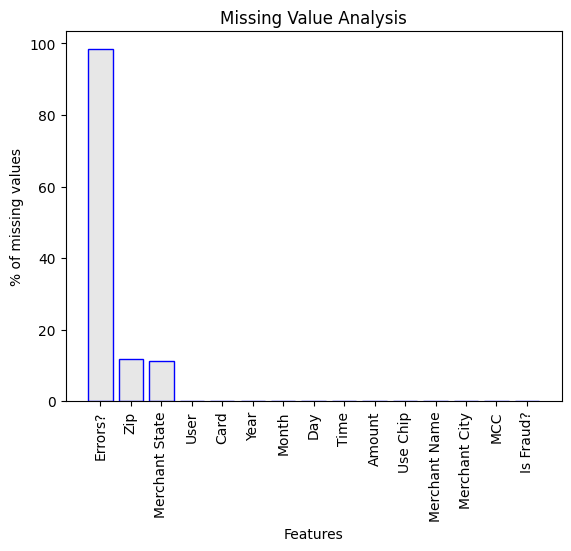

In [6]:
percent_missing=(df.isnull().sum()*100/df.shape[0]).sort_values(ascending=True)
plt.title("Missing Value Analysis")
plt.xlabel("Features")
plt.ylabel("% of missing values")
plt.bar(percent_missing.sort_values(ascending=False).index,percent_missing.sort_values(ascending=False),color=(0.1, 0.1, 0.1, 0.1),edgecolor='blue')
plt.xticks(rotation=90)

In [7]:
df["card_id"] = df["User"].astype(str) + "_" + df["Card"].astype(str)

In [8]:
df.Amount.head(5)

18199893      $59.18
9731325      $280.91
536687      $-144.00
13223840       $6.76
17070521       $9.17
Name: Amount, dtype: object

In [9]:
df["Amount"]=df["Amount"].str.replace("$","").astype(float)

In [10]:
df["Hour"] = df["Time"].str [0:2]
df["Minute"] = df["Time"].str [3:5]

In [11]:
df.Hour

18199893    00
9731325     22
536687      07
13223840    14
17070521    11
            ..
3028639     20
11275290    14
1327632     11
2929345     09
4816941     11
Name: Hour, Length: 100000, dtype: object

In [12]:
df.Minute

18199893    11
9731325     12
536687      07
13223840    58
17070521    44
            ..
3028639     37
11275290    12
1327632     15
2929345     51
4816941     08
Name: Minute, Length: 100000, dtype: object

In [13]:
df = df.drop(["Time","User","Card"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 18199893 to 4816941
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Year            100000 non-null  int64  
 1   Month           100000 non-null  int64  
 2   Day             100000 non-null  int64  
 3   Amount          100000 non-null  float64
 4   Use Chip        100000 non-null  object 
 5   Merchant Name   100000 non-null  int64  
 6   Merchant City   100000 non-null  object 
 7   Merchant State  88782 non-null   object 
 8   Zip             88134 non-null   float64
 9   MCC             100000 non-null  int64  
 10  Errors?         1576 non-null    object 
 11  Is Fraud?       100000 non-null  object 
 12  card_id         100000 non-null  object 
 13  Hour            100000 non-null  object 
 14  Minute          100000 non-null  object 
dtypes: float64(2), int64(5), object(8)
memory usage: 12.2+ MB


In [14]:
df["Errors?"].unique()

array([nan, 'Bad PIN', 'Insufficient Balance', 'Technical Glitch',
       'Bad Card Number', 'Bad CVV', 'Bad Expiration', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch', 'Bad Card Number,Bad CVV',
       'Bad CVV,Insufficient Balance',
       'Bad Card Number,Insufficient Balance'], dtype=object)

In [15]:
df["Errors?"]= df["Errors?"].fillna("No error")

In [16]:
df = df.drop(columns=["Merchant State","Zip"],axis=1)

In [17]:

df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

In [18]:
df["Merchant City"]=LabelEncoder().fit_transform(df["Merchant City"])
df["Use Chip"]=LabelEncoder().fit_transform(df["Use Chip"])
df["Errors?"]=LabelEncoder().fit_transform(df["Errors?"])

In [19]:

df["Errors?"].unique()

array([10,  6,  8, 11,  2,  0,  5,  7,  9,  3,  1,  4])

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 18199893 to 4816941
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Year           100000 non-null  int64  
 1   Month          100000 non-null  int64  
 2   Day            100000 non-null  int64  
 3   Amount         100000 non-null  float64
 4   Use Chip       100000 non-null  int64  
 5   Merchant Name  100000 non-null  int64  
 6   Merchant City  100000 non-null  int64  
 7   MCC            100000 non-null  int64  
 8   Errors?        100000 non-null  int64  
 9   Is Fraud?      100000 non-null  int64  
 10  card_id        100000 non-null  object 
 11  Hour           100000 non-null  object 
 12  Minute         100000 non-null  object 
dtypes: float64(1), int64(9), object(3)
memory usage: 10.7+ MB


## GNN

In [21]:
# Create an empty graph
G = nx.MultiGraph()

# Add nodes to the graph for each unique card_id, merchant_name
G.add_nodes_from(df["card_id"].unique(), type='card_id')
G.add_nodes_from(df["Merchant Name"].unique(), type='merchant_name')

In [22]:
# Add edges and properties to the edges
for _, row in df.iterrows():
    # Create a variable for each properties for each edge

        year = row["Year"],
        month = row["Month"],
        day = row["Day"],
        hour = row["Hour"],
        minute =row["Minute"],
        amount = row["Amount"],
        use_chip =  row["Use Chip"],
        merchant_city = row["Merchant City"],
        errors =  row["Errors?"],
        mcc = row['MCC']


        G.add_edge(row['card_id'], row['Merchant Name'], year = year , month = month , day = day ,
              hour = hour , minute = minute , amount = amount , use_chip = use_chip ,
              merchant_city = merchant_city , errors = errors , mcc = mcc)


In [23]:
# Get the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Print the number of nodes and edges
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)

Number of nodes: 16415
Number of edges: 100000


In [24]:
# Convert the graph to an adjacency matrix
adj_matrix = nx.adjacency_matrix(G).todense()

In [25]:
adj_matrix.shape

(16415, 16415)

### retrieve the properties of a small sample of nodes in our graph (G) and print their properties

In [26]:
# Get a small sample of the nodes in the graph
sample_nodes = list(G.nodes())[:10]

# Retrieve the properties of the sample nodes
node_properties = nx.get_node_attributes(G, 'type')

# Print the properties of the sample nodes
for node in sample_nodes:
    print(f"Node: {node}, Properties: {node_properties[node]}")

Node: 1470_0, Properties: card_id
Node: 822_1, Properties: card_id
Node: 41_3, Properties: card_id
Node: 1084_0, Properties: card_id
Node: 1384_0, Properties: card_id
Node: 55_3, Properties: card_id
Node: 776_0, Properties: card_id
Node: 66_0, Properties: card_id
Node: 1880_2, Properties: card_id
Node: 490_5, Properties: card_id


In [27]:
sample_size = 5
for i, edge in enumerate(G.edges()):
    print(G.get_edge_data(*edge))
    if i >= sample_size - 1:
        break

{0: {'year': (2019,), 'month': (7,), 'day': (10,), 'hour': ('00',), 'minute': ('11',), 'amount': (59.18,), 'use_chip': (0,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 1: {'year': (2019,), 'month': (10,), 'day': (1,), 'hour': ('00',), 'minute': ('22',), 'amount': (91.4,), 'use_chip': (0,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 2: {'year': (2011,), 'month': (9,), 'day': (27,), 'hour': ('00',), 'minute': ('00',), 'amount': (64.21,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 3: {'year': (2011,), 'month': (11,), 'day': (11,), 'hour': ('00',), 'minute': ('04',), 'amount': (64.36,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}, 4: {'year': (2009,), 'month': (11,), 'day': (25,), 'hour': ('00',), 'minute': ('18',), 'amount': (52.75,), 'use_chip': (2,), 'merchant_city': (1890,), 'errors': (10,), 'mcc': 5813}}
{0: {'year': (2019,), 'month': (7,), 'day': (10,), 'hour': ('00',), 'minute': ('11',), 'amoun

### retrieve the properties of a small sample of edges in our graph (G) and print their properties

In [28]:
# Retrieve the properties errors of all the edges
edge_properties = nx.get_edge_attributes(G, 'errors')

# Count the number of edges by property value
edge_count_by_property = Counter(edge_properties.values())

# Print the count of edges by property value
for property_value, count in edge_count_by_property.items():
    print(f"Property value: {property_value}, Count: {count}")

Property value: (10,), Count: 98424
Property value: (8,), Count: 1003
Property value: (6,), Count: 228
Property value: (5,), Count: 44
Property value: (0,), Count: 42
Property value: (11,), Count: 195
Property value: (2,), Count: 50
Property value: (4,), Count: 2
Property value: (1,), Count: 1
Property value: (9,), Count: 3
Property value: (7,), Count: 7
Property value: (3,), Count: 1


In [29]:
# Prepare the data for input into the model
edge_list = list(G.edges(data=True))

In [31]:
list(edge_list[i][2].values())

[(2009,), (11,), (25,), ('00',), ('18',), (52.75,), (2,), (1890,), (10,), 5813]

In [32]:
class FraudGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FraudGNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x.squeeze(-1)

# Prepare the data for input into the model
edge_list = list(G.edges(data=True))
x = []
for edge in edge_list:
    edge_values = list(edge[2].values())
    edge_values = [float(i[0]) if type(i) == tuple and type(i[0]) == str else i[0] if type(i) == tuple else i for i in edge_values]
    x.append(edge_values)
x = torch.tensor(x, dtype=torch.float)

In [33]:
target = torch.tensor(df['Is Fraud?'].values, dtype=torch.float)

In [34]:
# Define the model
input_dim = len(x[0])
hidden_dim = 16
model = FraudGNN(input_dim, hidden_dim)
num_epochs=201

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import f1_score

In [37]:
# Train the model
for i in range(num_epochs):
    # Forward pass
    output = model(x)
    # Compute the loss
    loss = criterion(output, target)
    if i % 20 == 0:
        # 计算 AUC 和 AP
        with torch.no_grad():
            output_prob = torch.sigmoid(output)
            auc = roc_auc_score(target.cpu().numpy(), output_prob.cpu().numpy())
            ap = average_precision_score(target.cpu().numpy(), output_prob.cpu().numpy())
            f1 = f1_score(target.cpu().numpy(), (output_prob > 0.5).cpu().numpy())
            auroc = roc_auc_score(target.cpu().numpy(), output_prob.cpu().numpy())
        print(f'Epoch: {i}, Loss: {loss.item()}, AUC: {auc}, AP: {ap}, F1: {f1}, AUROC: {auroc}')

    # Zero the gradients
    optimizer.zero_grad()
    # Perform backpropagation
    loss.backward()
    # Update the parameters
    optimizer.step()

Epoch: 0, Loss: 0.596289336681366, AUC: 0.4999149004335072, AP: 0.00117, F1: 0.0, AUROC: 0.4999149004335072
Epoch: 20, Loss: 0.37569141387939453, AUC: 0.49717169087832763, AP: 0.00117, F1: 0.0, AUROC: 0.49717169087832763
Epoch: 40, Loss: 0.21587324142456055, AUC: 0.49969331639385606, AP: 0.001190264037029278, F1: 0.0, AUROC: 0.49969331639385606
Epoch: 60, Loss: 0.0992935374379158, AUC: 0.5143145685580335, AP: 0.001358631607040287, F1: 0.0, AUROC: 0.5143145685580335
Epoch: 80, Loss: 0.04016108810901642, AUC: 0.5210708494750824, AP: 0.0013695395234406035, F1: 0.0, AUROC: 0.5210708494750824
Epoch: 100, Loss: 0.031512659043073654, AUC: 0.5182091679743933, AP: 0.0013662832719808938, F1: 0.0, AUROC: 0.5182091679743933
Epoch: 120, Loss: 0.02520722709596157, AUC: 0.5247262801751553, AP: 0.001593705490696011, F1: 0.0, AUROC: 0.5247262801751553
Epoch: 140, Loss: 0.02188126929104328, AUC: 0.5345863634811703, AP: 0.0014363682046464696, F1: 0.0, AUROC: 0.5345863634811703
Epoch: 160, Loss: 0.0198783